In [3]:
from model.speed_limit_detector import SpeedLimitDetector
from defense.hgd_trainer import get_HGD_model
import numpy as np
import matplotlib.pyplot as plt
import torch
from glob import glob
import cv2
from tqdm.auto import tqdm

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
batch_size = 8

cuda


In [5]:
model_name = "mix_ckpt"
detector = SpeedLimitDetector(device, model_name + ".pth")

if (model_name == "mix_ckpt"):
    hgd = get_HGD_model(device, width=0.5, growth_rate=16, bn_size=2, checkpoint_name= model_name + ".pt")
    img_paths = glob('../model/datasets/all_test_dataset/*') 
else:
    if (model_name == "carla_ckpt"):
        img_paths = glob('../model/datasets/carla-speedlimit-signs/test2017/*') 
    else:
        img_paths = glob('../model/datasets/tsinghua_gtsdb_speedlimit/test2017/*')
        
    hgd = get_HGD_model(device, checkpoint_name= model_name + ".pt")

In [6]:
preprocessed_imgs = []
for img_path in img_paths:
    img = cv2.imread(img_path)
    img = detector.preprocess(img)
    preprocessed_imgs.append(img)

In [7]:
print(len(preprocessed_imgs))

304


In [8]:
def plot_images(images, title="",transpose=False, rgb=True):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
    fig.suptitle(title, fontsize=16)
    axs = axs.flatten()
    for i, img in enumerate(images):
        img = img.transpose((1, 2, 0)) if transpose else img
        img = np.asarray(img, dtype=np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if rgb else img
        axs[i].imshow(img)
        axs[i].axis('off')
    plt.show()

In [9]:
@torch.no_grad()
def denoise(images):
    images_tensor = torch.from_numpy(np.asarray(images)).to(device)
    hgd.eval()
    noise = hgd(images_tensor)
    denoised = images_tensor - noise
    return denoised.cpu().numpy(), noise.cpu().numpy()

In [10]:
@torch.no_grad()
def detect_sign(images):
    images_tensor = torch.from_numpy(np.asarray(images)).to(device)
    outputs = detector.get_model_output(images_tensor)
    decoded_outputs = []
    for output in outputs:
        decoded_outputs.append(detector.decode_model_output(output))
    return decoded_outputs

In [11]:
@torch.no_grad()
def get_iou(box1, box2):

    # xmin, ymin, xmax, ymax = box
    
    x11, y11, x21, y21 = box1
    x12, y12, x22, y22 = box2
    
    yi1 = max(y11, y12)
    xi1 = max(x11, x12)
    yi2 = min(y21, y22)
    xi2 = min(x21, x22)
    inter_area = max(((xi2 - xi1) * (yi2 - yi1)), 0)
    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (x21 - x11) * (y21 - y11)
    box2_area = (x22 - x12) * (y22 - y12)
    union_area = box1_area + box2_area - inter_area
    # compute the IoU
    iou = inter_area / union_area
    return iou

In [12]:
@torch.no_grad()
def calculate_metric(results_to_be_measured,results_name:str):
    results = []
    conf_threshold = 0.8
    IOU_threshold = 0.75
    avg_conf = 0
    conf_count = 0
    for i, result in enumerate(results_to_be_measured):
        if result is not None:
            (clss, confs, bbs) = result[0],result[1],result[2]
        elif benign_images_results[i] is None:
            results.append(1)
            continue
        else:
            results.append(0)
            continue
        for cls, conf, bb in zip(clss,confs,bbs):
            if conf < conf_threshold:
                continue
            
            avg_conf += conf
            conf_count += 1
            
            if benign_images_results[i] is None:
                results.append(0)
                continue
            
            if benign_images_results[i][2].shape[0] > 1:

                max_iou = 0

                for bb_idx, bb_benign in enumerate(benign_images_results[i][2]):

                    IOU = get_iou(bb,bb_benign)
                    if IOU > max_iou:
                        max_iou = IOU
                        idx = bb_idx

            else:
                max_iou = get_iou(bb,benign_images_results[i][2][0])
                idx = 0

            if max_iou < IOU_threshold:
                results.append(0)
                continue
                
            if cls == benign_images_results[i][0][idx]:
                results.append(1)
            else:
                results.append(0)


    print(f"{np.asarray(results).mean():.4f} of bounding boxes in {results_name} are correct\nNumber of non-rejected bounding boxes {conf_count} \nAverage confidence of non-rejected bounding boxes is {avg_conf/conf_count}")

In [13]:
@torch.no_grad()
def calculate_recall_metric(results_to_be_measured,results_name:str):
    results = []
    conf_threshold = 0.8
    IOU_threshold = 0.75
    avg_conf = 0
    conf_count = 0
    for i, benign_result in enumerate(benign_images_results):
        if benign_result is not None:
            (benign_clss, benign_confs, benign_bbs) = benign_result[0],benign_result[1],benign_result[2]
        else:
            continue
        
        for benign_cls, benign_conf, benign_bb in zip(benign_clss,benign_confs,benign_bbs):
            if benign_conf < conf_threshold:
                continue
            
            avg_conf += benign_conf
            conf_count += 1

            if results_to_be_measured[i] is None:
                results.append(0)
                continue
            
            if results_to_be_measured[i][2].shape[0] > 1:

                max_iou = 0

                for bb_idx, bb in enumerate(results_to_be_measured[i][2]):

                    IOU = get_iou(bb,benign_bb)
                    if IOU > max_iou:
                        max_iou = IOU
                        idx = bb_idx

            else:
                max_iou = get_iou(benign_bb,results_to_be_measured[i][2][0])
                idx = 0

            if max_iou < IOU_threshold:
                results.append(0)
                continue
                
            if benign_cls == results_to_be_measured[i][0][idx]:
                results.append(1)
            else:
                results.append(0)


    print(f"Recall Metric of {results_name} is {np.asarray(results).mean():.4f}\nNumber of non-rejected bounding boxes {conf_count} \nAverage confidence of non-rejected bounding boxes is {avg_conf/conf_count}")

## Setup all attack methods

In [14]:
from attack.fgsm import FGSM
from attack.iterative_fgsm import ItFGSM
from model.custom_yolo import yolox_loss, yolox_target_generator

fgsm = FGSM(yolox_target_generator, yolox_loss, detector.model)

it_fgsm = ItFGSM(yolox_target_generator, yolox_loss, detector.model)

## Generate Attacked Images
### Run one attack at a time to reduce memory usage

In [15]:
fgsm_attacked_images = []
it_fgsm_attacked_images = []
pgd_attacked_images = []

for img in tqdm(preprocessed_imgs):
    img = torch.from_numpy(img[None, :, :, :]).to(device)
    fgsm_attacked = fgsm.generate_attack(img, return_numpy=True)[0]
    it_fgsm_attacked = it_fgsm.generate_attack(img, return_numpy=True)[0]

    fgsm_attacked_images.append(fgsm_attacked)
    it_fgsm_attacked_images.append(it_fgsm_attacked)

  0%|          | 0/304 [00:00<?, ?it/s]

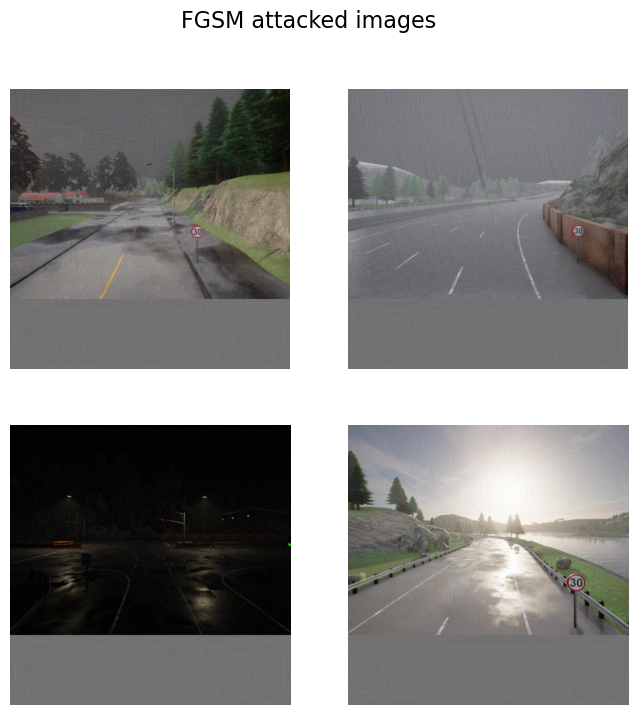

In [16]:
plot_images(fgsm_attacked_images[-5:-1], transpose = True, title = "FGSM attacked images")

## Get Benign Image Results and Denoise Benign Images

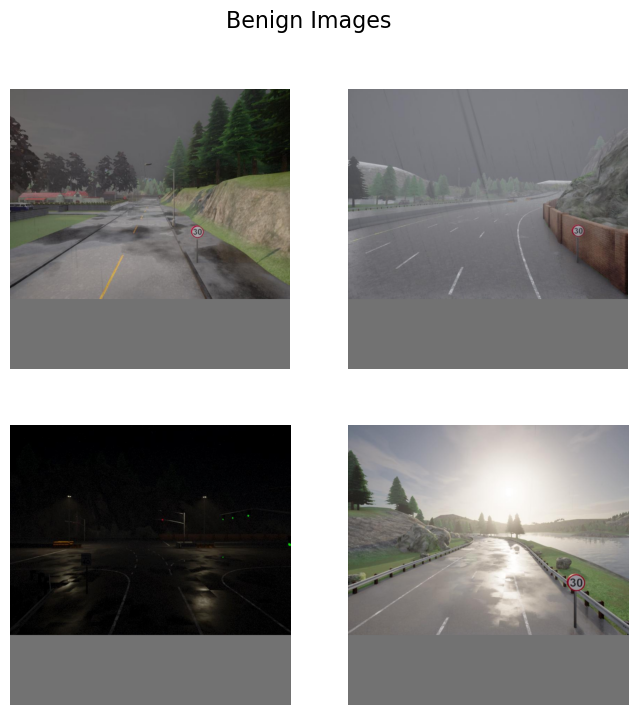

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/304 [00:00<?, ?it/s]

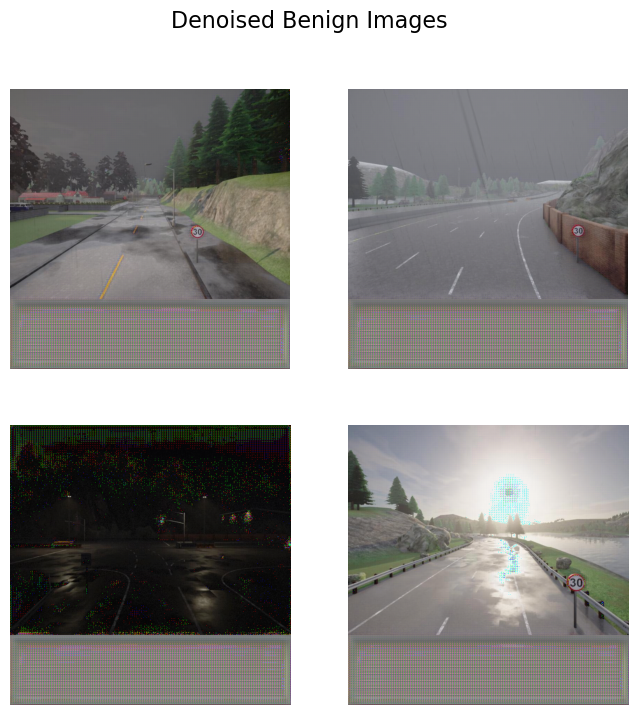

In [17]:
plot_images(preprocessed_imgs[-5:-1], transpose = True, title = "Benign Images")
with torch.no_grad():
    benign_images_results = []
    for start_idx in tqdm(range(0,len(preprocessed_imgs),batch_size)):
        benign_images_results.extend(detect_sign(preprocessed_imgs[start_idx:start_idx+batch_size]))

    denoised_benign_images = []
    noise_benign_images = []
    for img in tqdm(preprocessed_imgs):
        denoised_result, noise_result = denoise([img])
        denoised_benign_images.extend(denoised_result)
        noise_benign_images.extend(noise_result)

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
    fig.suptitle("Denoised Benign Images", fontsize=16)
    axs = axs.flatten()
    for i, img in enumerate(denoised_benign_images[-5:-1]):
        img = img.transpose((1, 2, 0))
        img = np.asarray(img, dtype=np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        axs[i].imshow(img)
        axs[i].axis('off')
    plt.show()

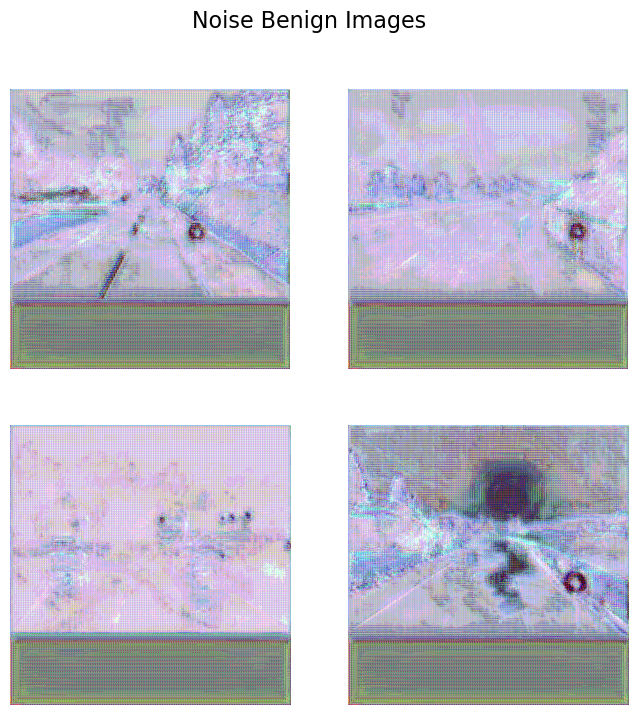

In [18]:
plot_images(noise_benign_images[-5:-1], transpose=True, title= "Noise Benign Images")

## Denoise FGSM Images and Get Model Results

  0%|          | 0/38 [00:00<?, ?it/s]

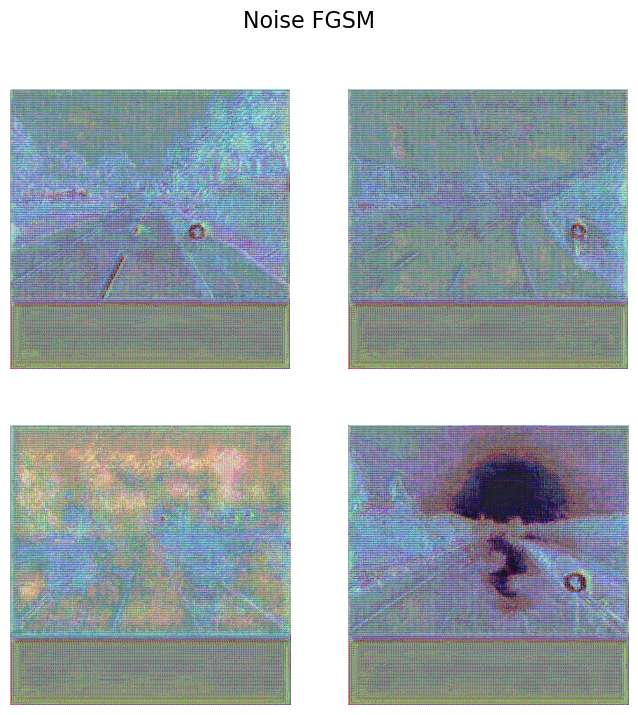

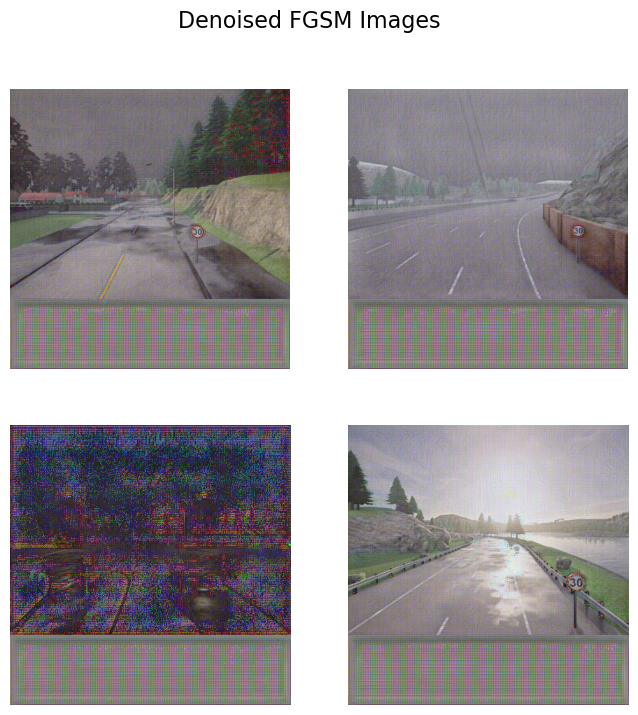

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/304 [00:00<?, ?it/s]

In [19]:
denoised_fgsm = []
noise_fgsm = []
with torch.no_grad():
    for start_idx in tqdm(range(0,len(fgsm_attacked_images),batch_size)):
        results_tuple = denoise(fgsm_attacked_images[start_idx:start_idx+batch_size])
        denoised_fgsm.extend(results_tuple[0])
        noise_fgsm.extend(results_tuple[1]) 

    
    plot_images(noise_fgsm[-5:-1], title="Noise FGSM",transpose=True, rgb = True)
    plot_images(denoised_fgsm[-5:-1], title="Denoised FGSM Images",transpose=True, rgb=True)
    
    denoised_fgsm_results = []
    for start_idx in tqdm(range(0,len(denoised_fgsm),batch_size)):
        denoised_fgsm_results.extend(detect_sign(denoised_fgsm[start_idx:start_idx+batch_size]))

    for i,element in enumerate(tqdm(denoised_fgsm_results)):
        if element is None:
            continue
        denoised_fgsm_results[i] = list(element)
        

## Get Model Results for Denoised Benign Images

In [20]:
with torch.no_grad():
    denoised_benign_results = []
    for start_idx in tqdm(range(0,len(denoised_benign_images),batch_size)):
        denoised_benign_results.extend(detect_sign(denoised_benign_images[start_idx:start_idx+batch_size]))
    
    for i,element in enumerate(tqdm(denoised_benign_results)):
        if element is None:
            continue
        denoised_benign_results[i] = list(element)

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/304 [00:00<?, ?it/s]

## Get Model Results for FGSM Images

In [21]:
with torch.no_grad():    
    fgsm_results = []
    for start_idx in tqdm(range(0,len(fgsm_attacked_images),batch_size)):
        fgsm_results.extend(detect_sign(fgsm_attacked_images[start_idx:start_idx+batch_size]))
    
    for i,element in enumerate(tqdm(fgsm_results)):
        if element is None:
            continue
        fgsm_results[i] = list(element)

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/304 [00:00<?, ?it/s]

## Get Model Results for IT-FGSM Images

In [22]:
with torch.no_grad():    
    it_fgsm_results = []
    for start_idx in tqdm(range(0,len(it_fgsm_attacked_images),batch_size)):
        it_fgsm_results.extend(detect_sign(it_fgsm_attacked_images[start_idx:start_idx+batch_size]))
    
    for i,element in enumerate(tqdm(it_fgsm_results)):
        if element is None:
            continue
        it_fgsm_results[i] = list(element)

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/304 [00:00<?, ?it/s]

## Metric Results

In [23]:
calculate_metric(denoised_benign_results, "Denoised Benign")

1.0000 of bounding boxes in Denoised Benign are correct
Number of non-rejected bounding boxes 308 
Average confidence of non-rejected bounding boxes is 0.9248844435462704


In [24]:
calculate_metric(fgsm_results, "FGSM Images")

0.7317 of bounding boxes in FGSM Images are correct
Number of non-rejected bounding boxes 345 
Average confidence of non-rejected bounding boxes is 0.8903975849566252


In [25]:
calculate_metric(denoised_fgsm_results, "denoised FGSM")

0.8857 of bounding boxes in denoised FGSM are correct
Number of non-rejected bounding boxes 291 
Average confidence of non-rejected bounding boxes is 0.9089105850232836


## Recall Metric Results

In [26]:
calculate_recall_metric(denoised_benign_results, "denoised benign images")

Recall Metric of denoised benign images is 1.0000
Number of non-rejected bounding boxes 308 
Average confidence of non-rejected bounding boxes is 0.9263993439736304


In [27]:
calculate_recall_metric(fgsm_results, "FGSM Images")

Recall Metric of FGSM Images is 0.8604
Number of non-rejected bounding boxes 308 
Average confidence of non-rejected bounding boxes is 0.9263993439736304


In [28]:
calculate_recall_metric(denoised_fgsm_results, "denoised FGSM")

Recall Metric of denoised FGSM is 0.8994
Number of non-rejected bounding boxes 308 
Average confidence of non-rejected bounding boxes is 0.9263993439736304


## Denoise IT-FGSM Images and Get Model Results

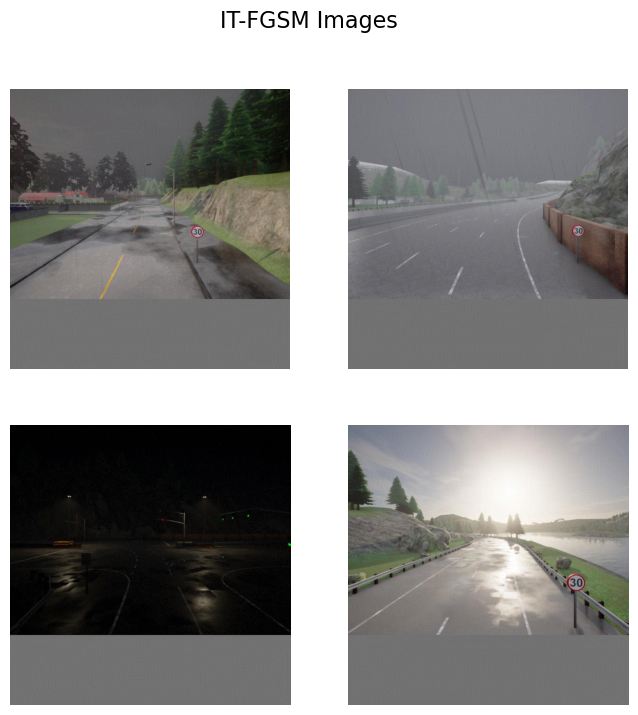

In [29]:
plot_images(it_fgsm_attacked_images[-5:-1], transpose=True,title = "IT-FGSM Images")

In [30]:
denoised_it_fgsm = []
noise_it_fgsm = []
with torch.no_grad():
    for start_idx in tqdm(range(0,len(it_fgsm_attacked_images),batch_size)):
        results_tuple = denoise(it_fgsm_attacked_images[start_idx:start_idx+batch_size])
        denoised_it_fgsm.extend(results_tuple[0])
        noise_it_fgsm.extend(results_tuple[1]) 
    
    # plot_images(noise_it_fgsm[-5:-1], title="Noise IT-FGSM",transpose=True, rgb = True)
    # plot_images(denoised_it_fgsm[-5:-1], title="Denoised IT-FGSM Images",transpose=True, rgb=True)
    
    denoised_it_fgsm_results = []
    for start_idx in tqdm(range(0,len(denoised_it_fgsm),batch_size)):
        denoised_it_fgsm_results.extend(detect_sign(denoised_it_fgsm[start_idx:start_idx+batch_size]))
        
    for i,element in enumerate(tqdm(denoised_it_fgsm_results)):
        if element is None:
            continue
        denoised_it_fgsm_results[i] = list(element)

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/304 [00:00<?, ?it/s]

In [31]:
# denoised, noise = denoise(it_fgsm_attacked_images[-5:-1])
# plot_images(noise[:4], title="Noise",transpose=True)
# plot_images(denoised[:4], title="Denoised Images",transpose=True)
# denoised_it_fgsm_results_demo = detect_sign(denoised)

In [32]:
calculate_metric(it_fgsm_results,"IT-FGSM Images")

0.0253 of bounding boxes in IT-FGSM Images are correct
Number of non-rejected bounding boxes 23112 
Average confidence of non-rejected bounding boxes is 0.884005317667563


In [33]:
calculate_metric(denoised_it_fgsm_results, "denoised IT-FGSM")

0.1875 of bounding boxes in denoised IT-FGSM are correct
Number of non-rejected bounding boxes 1633 
Average confidence of non-rejected bounding boxes is 0.859136085530694


In [34]:
calculate_recall_metric(it_fgsm_results,"IT-FGSM Images")

Recall Metric of IT-FGSM Images is 0.4026
Number of non-rejected bounding boxes 308 
Average confidence of non-rejected bounding boxes is 0.9263993439736304


In [35]:
calculate_recall_metric(denoised_it_fgsm_results, "denoised IT-FGSM")

Recall Metric of denoised IT-FGSM is 0.7662
Number of non-rejected bounding boxes 308 
Average confidence of non-rejected bounding boxes is 0.9263993439736304
